In [2]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [4]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [5]:
path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L"

In [6]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2:][0]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) > 0:
        paths[key] = li

In [7]:
for key, value in paths.items():
    print(key)

RecV3_2_ang+
RecV3_3_ang+
RecV3_4_ang+
RecV3_1_ang-


In [7]:
min_per_epoch = 10
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = ["Power",
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1]),
        ]

data = []
for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))        
data.append("Acceleration")
data.append("Subject")
data.append("Record")

data = pd.DataFrame(columns=data)

start_epoc = 0
counter = 0

for key, value in paths.items():
    for name in value:

        # read EEG and acceleration data
        raw_data = mne.io.read_raw_edf(name)
            
        fs = round(raw_data.info['sfreq'])
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])        

#         if name == "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf":
#             df = df.iloc[:, 100000:200000]
        
        # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
        n_epocs = int(np.floor(df.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = fs*SEC_PER_MIN*min_per_epoch

        data_new = {}
        
#         n = 0
        for chan in chans:

            # low-pass filter
            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_lo = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter
            
            # high-pass filter
            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])
            
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_hi[1000:15000]), label="{} {}".format(chan, kinds[1]))
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_lo[1000:15000]), label="{} {}".format(chan, kinds[2]))
            
            # band power data
            data_new.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_lo[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
            })
            
            del df_epocs_lo, df_epocs_hi

        acc_sign = df_epocs["STI 014"].diff().fillna(0)    
        
        # acceleration data
        data_new.update({
            "Acceleration": np.array(list(map(lambda i: (acc_sign.iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
                        })
        
#         subplot(5, 1, 5)
#         plot(standardize(df_epocs["STI 014"].iloc[1000:15000]), label="Acceleration")
#         title(name)
#         legend()
#         show()
        
        data_new = pd.DataFrame(data_new)
        data_new["Subject"] = key
        data_new["Record"] = counter
        
        data = pd.concat([data, data_new])
        
        start_epoc += n_epocs
        counter += 1
        
data = data.reset_index(drop=True)

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/01-02-2019_14-22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fut

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/31-01-2019_15-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/01-02-2019_14-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/31-01-2019_15-28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/01-02-2019_14-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/31-01-2019_15-43.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/31-01-2019_15-23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-c8d2ba33c873>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


In [8]:
data = pd.read_csv("lactate.csv")

In [9]:
data

,Unnamed: 0,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record
0,0,0.052623,6.531277e-10,3.730016e-10,0.015674,8.613710e-10,5.478058e-10,2547.095267,RecV3_2_ang+,0
1,1,0.052381,7.078631e-10,3.547715e-10,0.015731,9.739003e-10,6.458519e-10,7500.137287,RecV3_2_ang+,0
2,2,0.052695,7.490636e-10,3.687336e-10,0.015726,1.045216e-09,4.921154e-10,11025.941513,RecV3_2_ang+,0
3,3,0.051439,1.339146e-09,8.932669e-10,0.015169,1.529059e-09,1.291583e-09,1628.597667,RecV3_2_ang+,0
4,4,0.051249,1.479208e-09,1.035160e-09,0.015380,1.598738e-09,1.412246e-09,30.349760,RecV3_2_ang+,0
5,5,0.052481,1.405761e-09,9.917697e-10,0.016057,1.561561e-09,1.458779e-09,1922.540020,RecV3_2_ang+,0
6,6,0.052336,6.601896e-09,2.317291e-09,0.016073,1.000851e-09,5.941287e-10,8262.237420,RecV3_2_ang+,0
7,7,0.051320,1.457790e-09,1.014493e-09,0.015845,1.593587e-09,1.395374e-09,45.900480,RecV3_2_ang+,0
8,8,0.053067,1.473730e-09,9.377440e-10,0.015804,1.559042e-09,1.318753e-09,499.234193,RecV3_2_ang+,0
9,9,0.053207,1.694818e-09,1.086684e-09,0.016318,1.759961e-09,1.561769e-09,321.962827,RecV3_2_ang+,0


In [23]:
data.to_csv("lactate.csv")

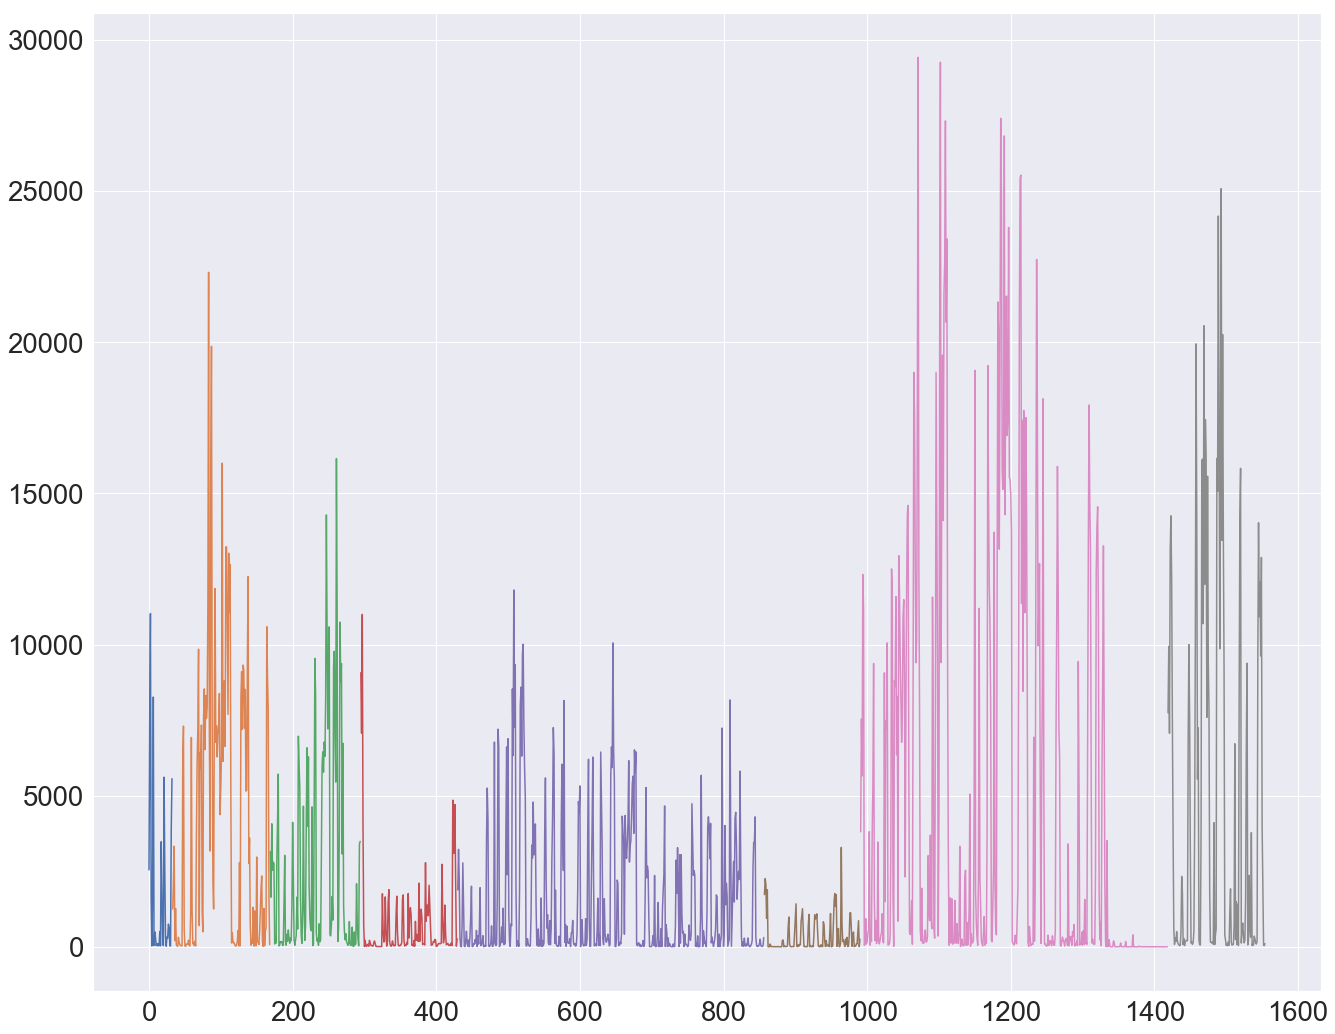

In [9]:
for i in np.arange(8):
    data[data["Record"]==i]["Acceleration"].plot()
#     data[data["Record"]==i]["Acceleration"].shape[0]/10

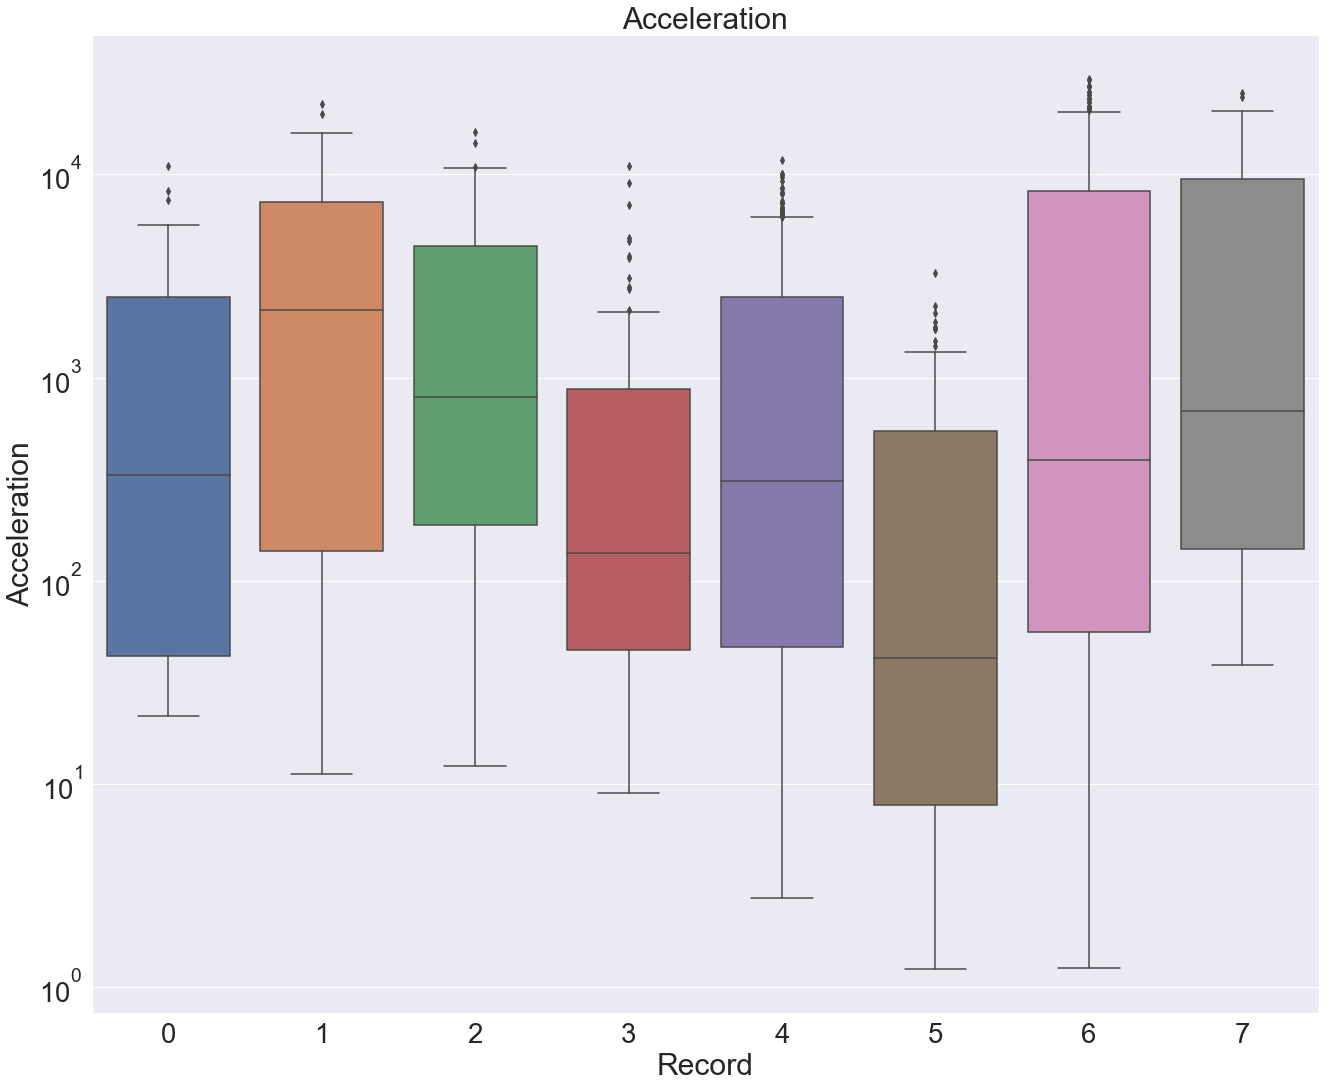

In [10]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Record", y="Acceleration", data=data, ax=ax)
title("Acceleration")
show()

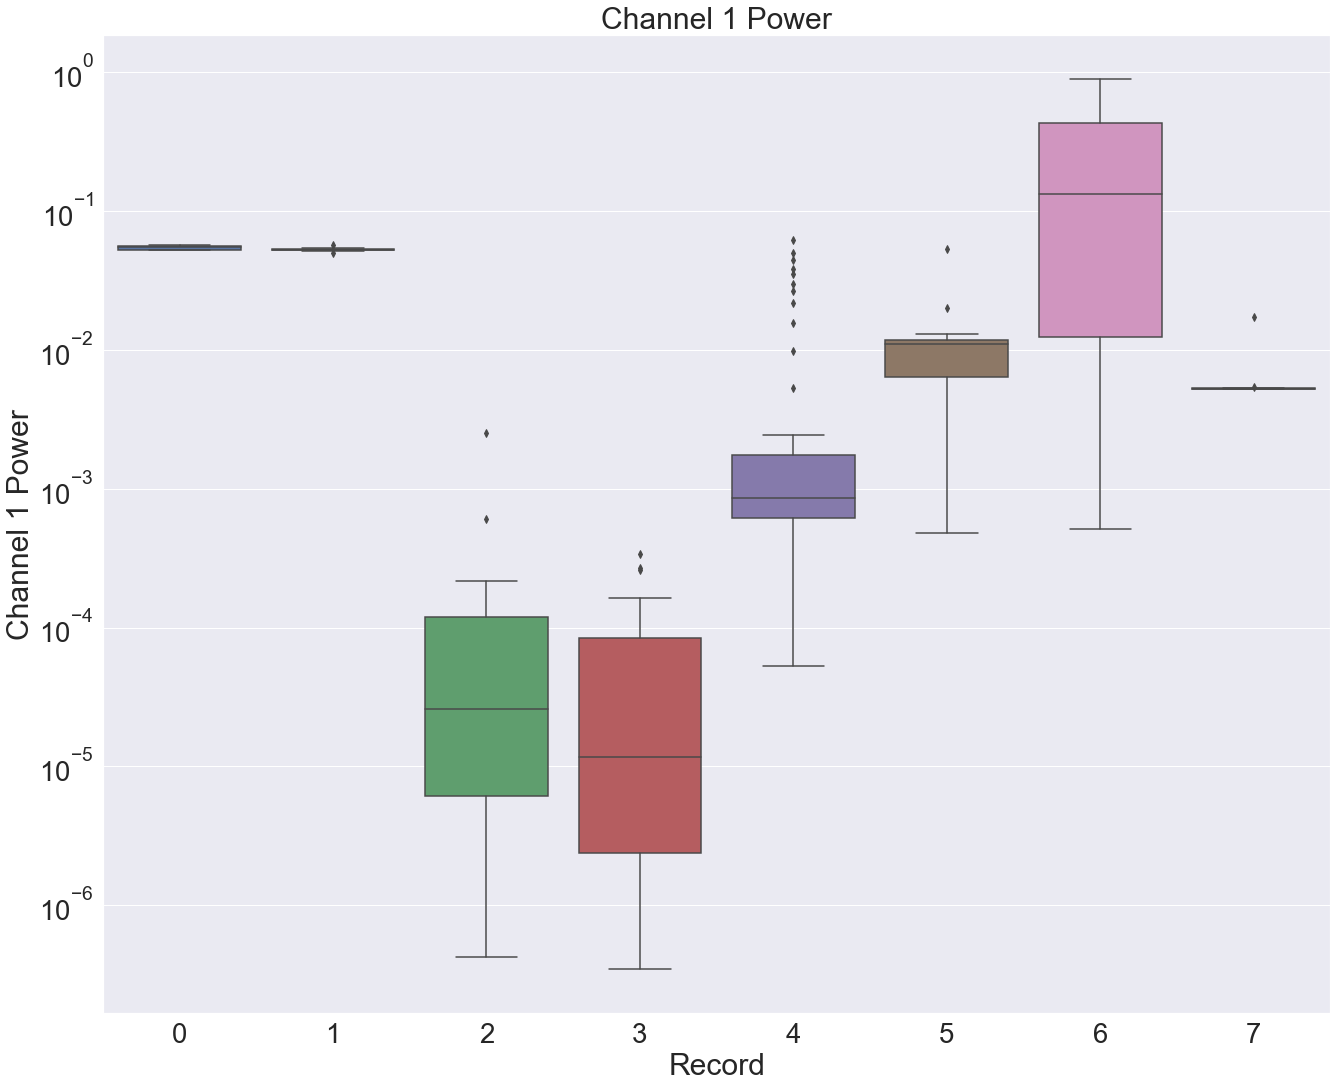

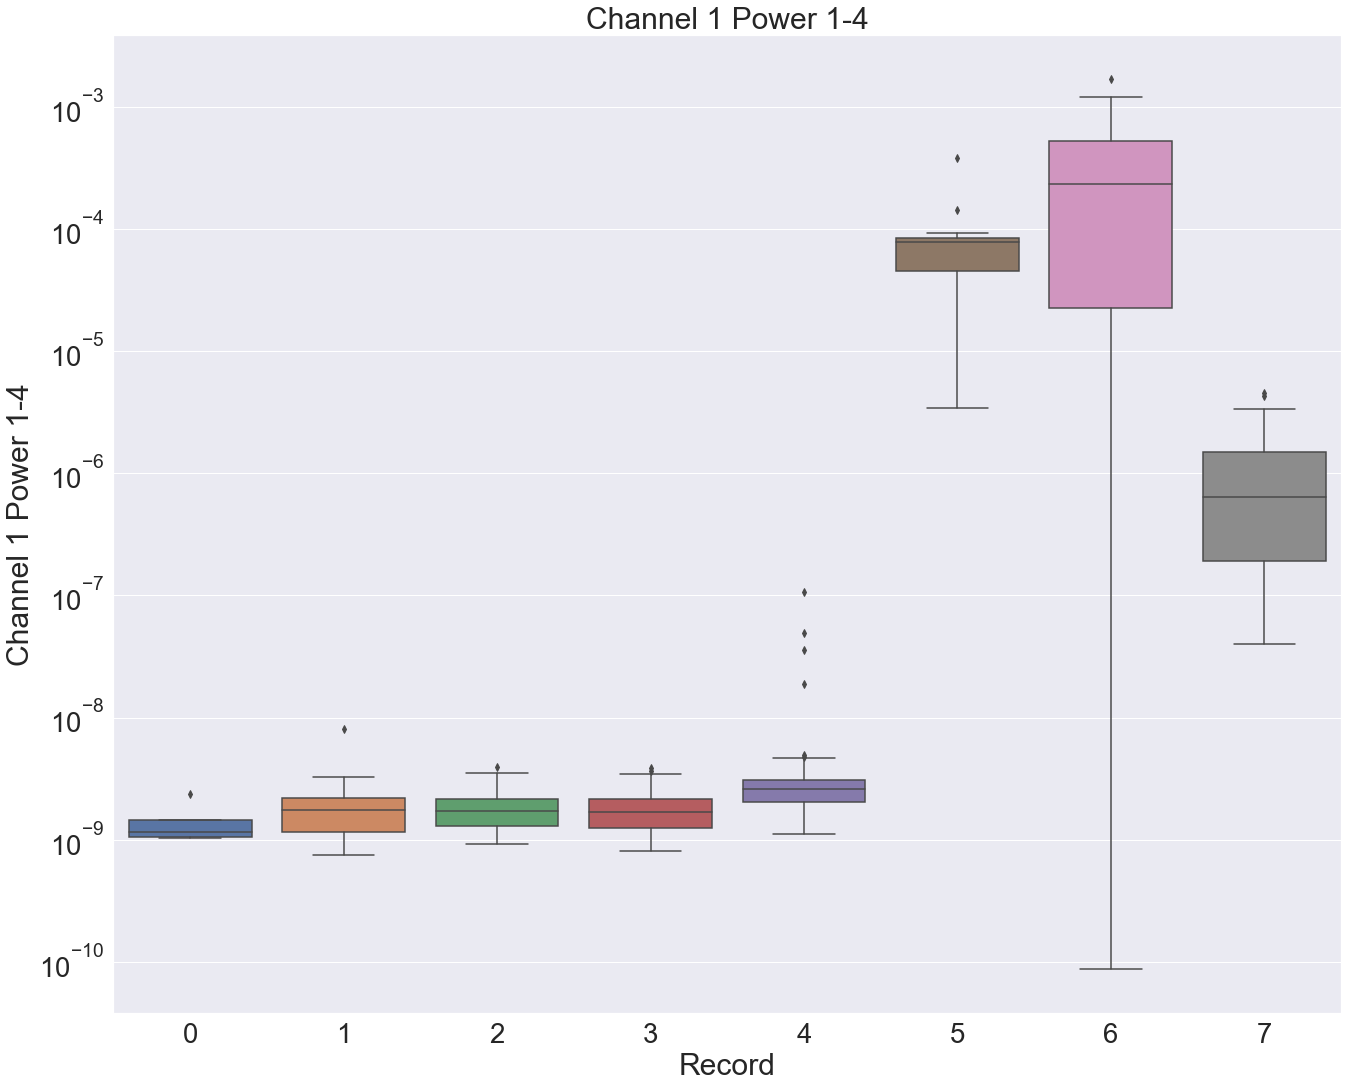

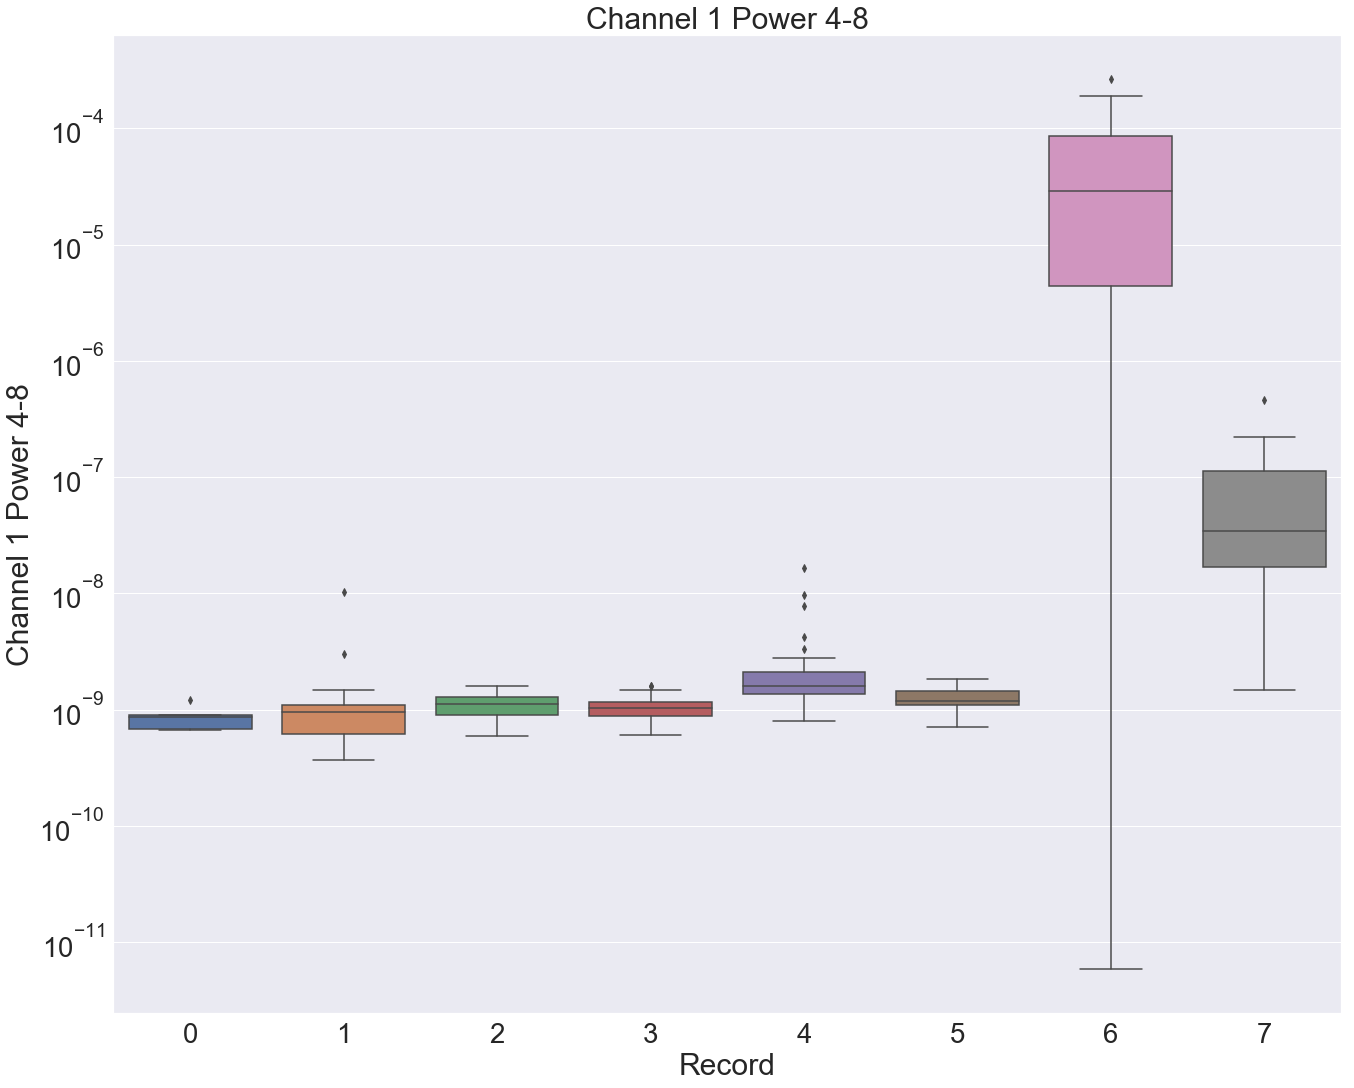

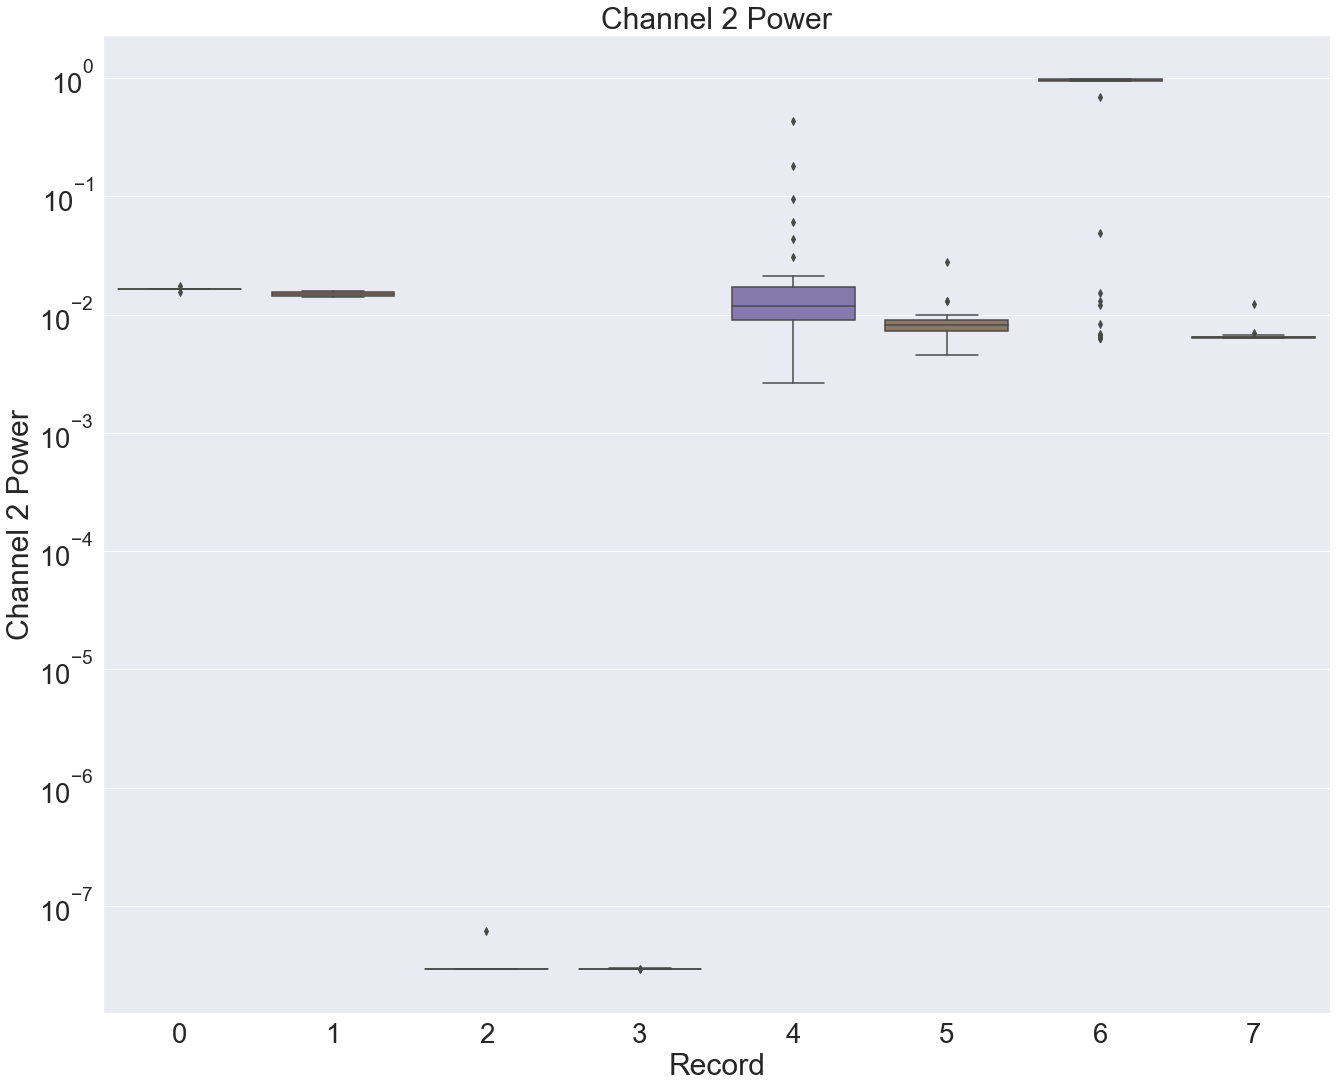

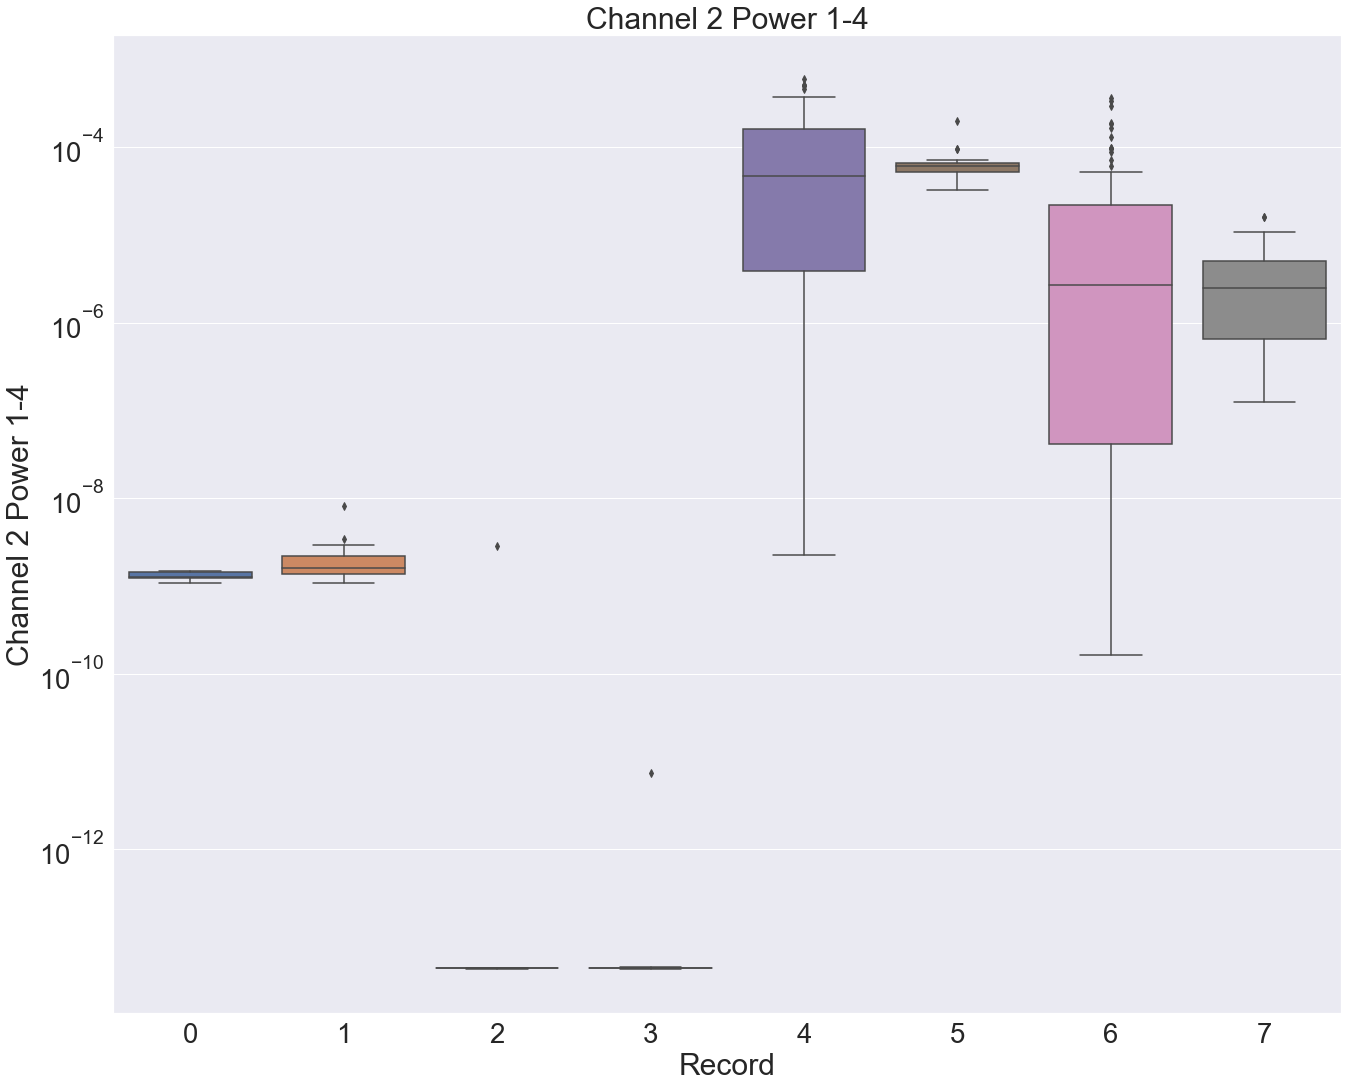

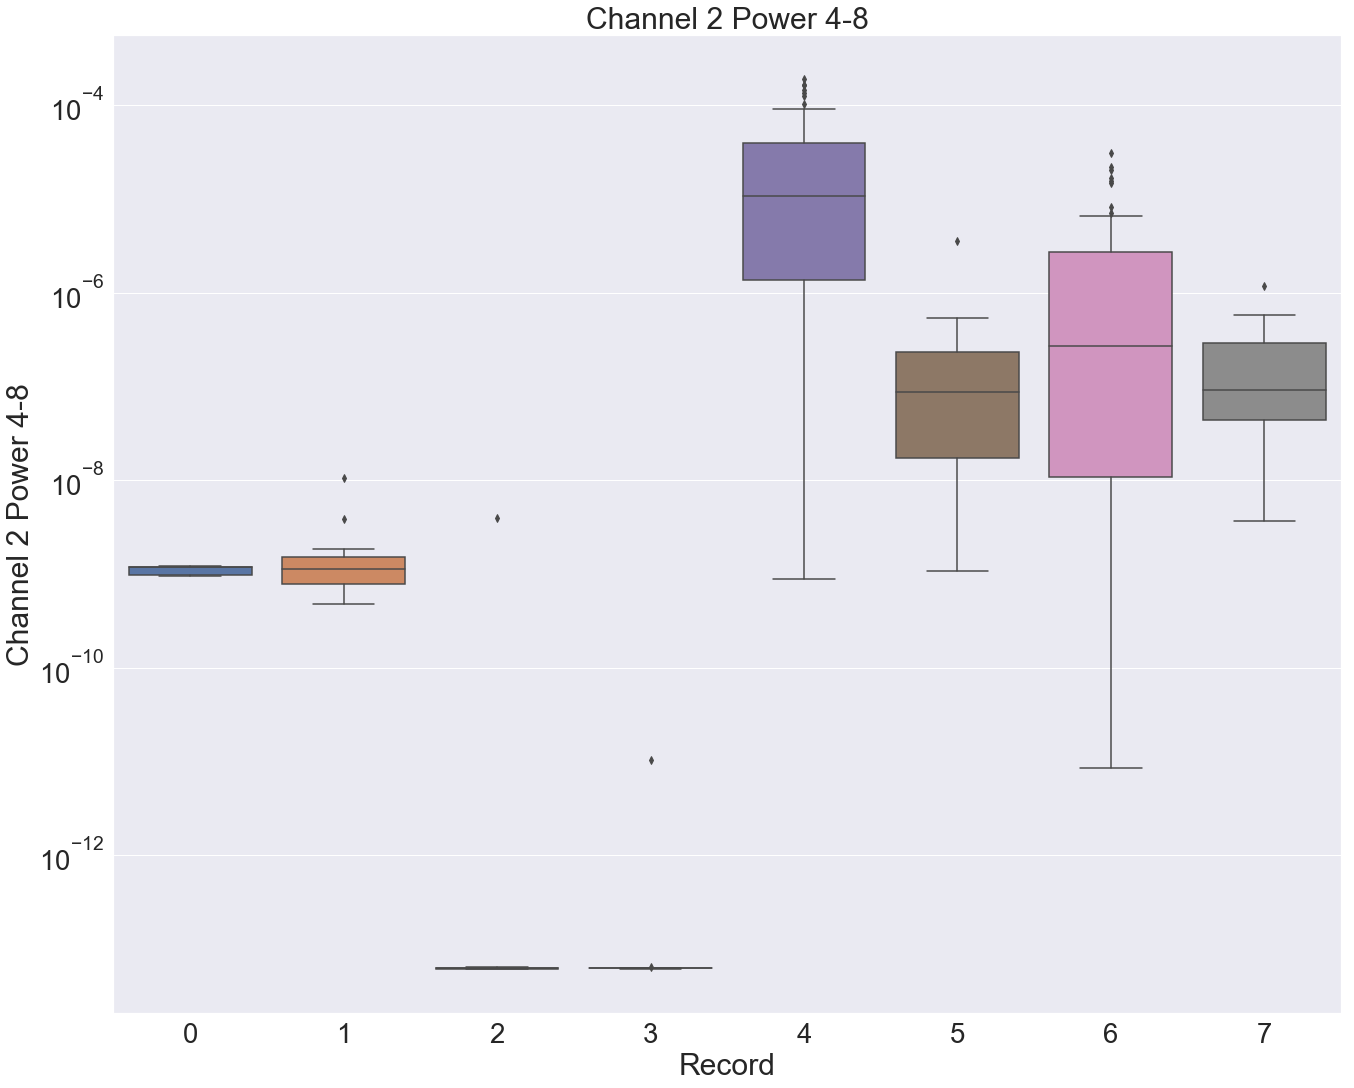

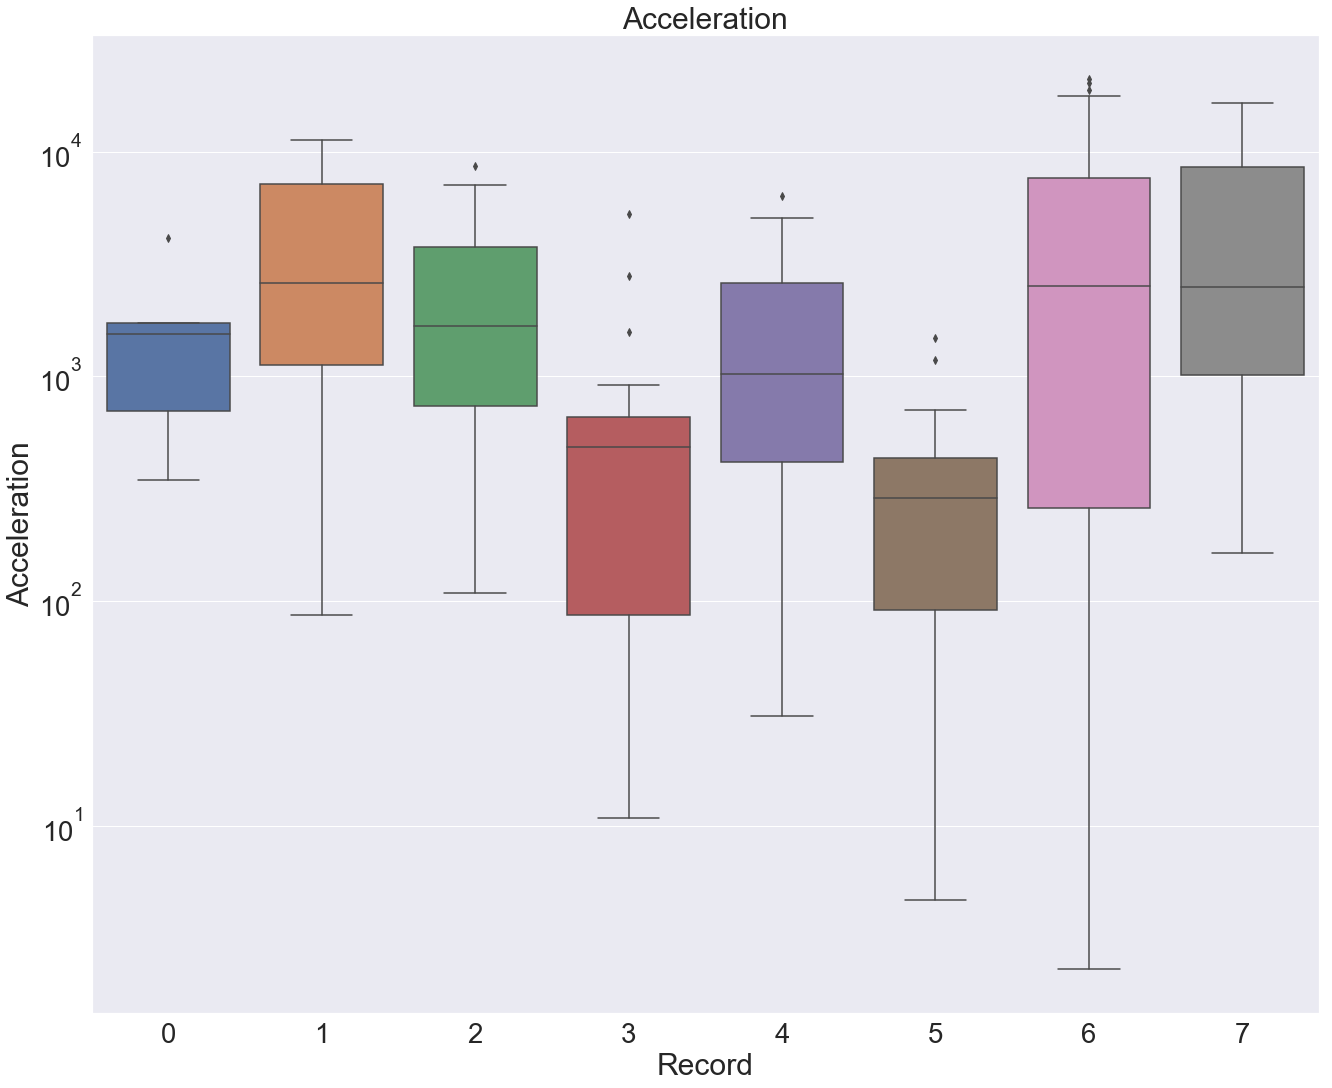

In [84]:
for name in data.columns[:-2]:

    f, ax = plt.subplots()
    ax.set(yscale="log")
    sns.boxplot(x="Record", y=name, data=data, ax=ax)
    title(name)
    show()

In [12]:
power = pd.concat([
    data[data["Record"]==0].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==1].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==2].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==3].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==4].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==5].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==6].loc[:, "Channel 2 Power 4-8"],
    data[data["Record"]==7].loc[:, "Channel 1 Power 4-8"]
])

record = data["Record"]

new_df = pd.concat([power, record], axis=1)
new_df = new_df.rename(columns={0: "Power 4-8"})
new_df
#           names = ["Power 4-8", "Record"])
# data[data["Record"]==6]["Channel 1 Power 4-8"],
# data[data["Record"]==7]["Channel 1 Power 4-8"],

,Power 4-8,Record
0,3.730016e-10,0
1,3.547715e-10,0
2,3.687336e-10,0
3,8.932669e-10,0
4,1.035160e-09,0
5,9.917697e-10,0
6,2.317291e-09,0
7,1.014493e-09,0
8,9.377440e-10,0
9,1.086684e-09,0


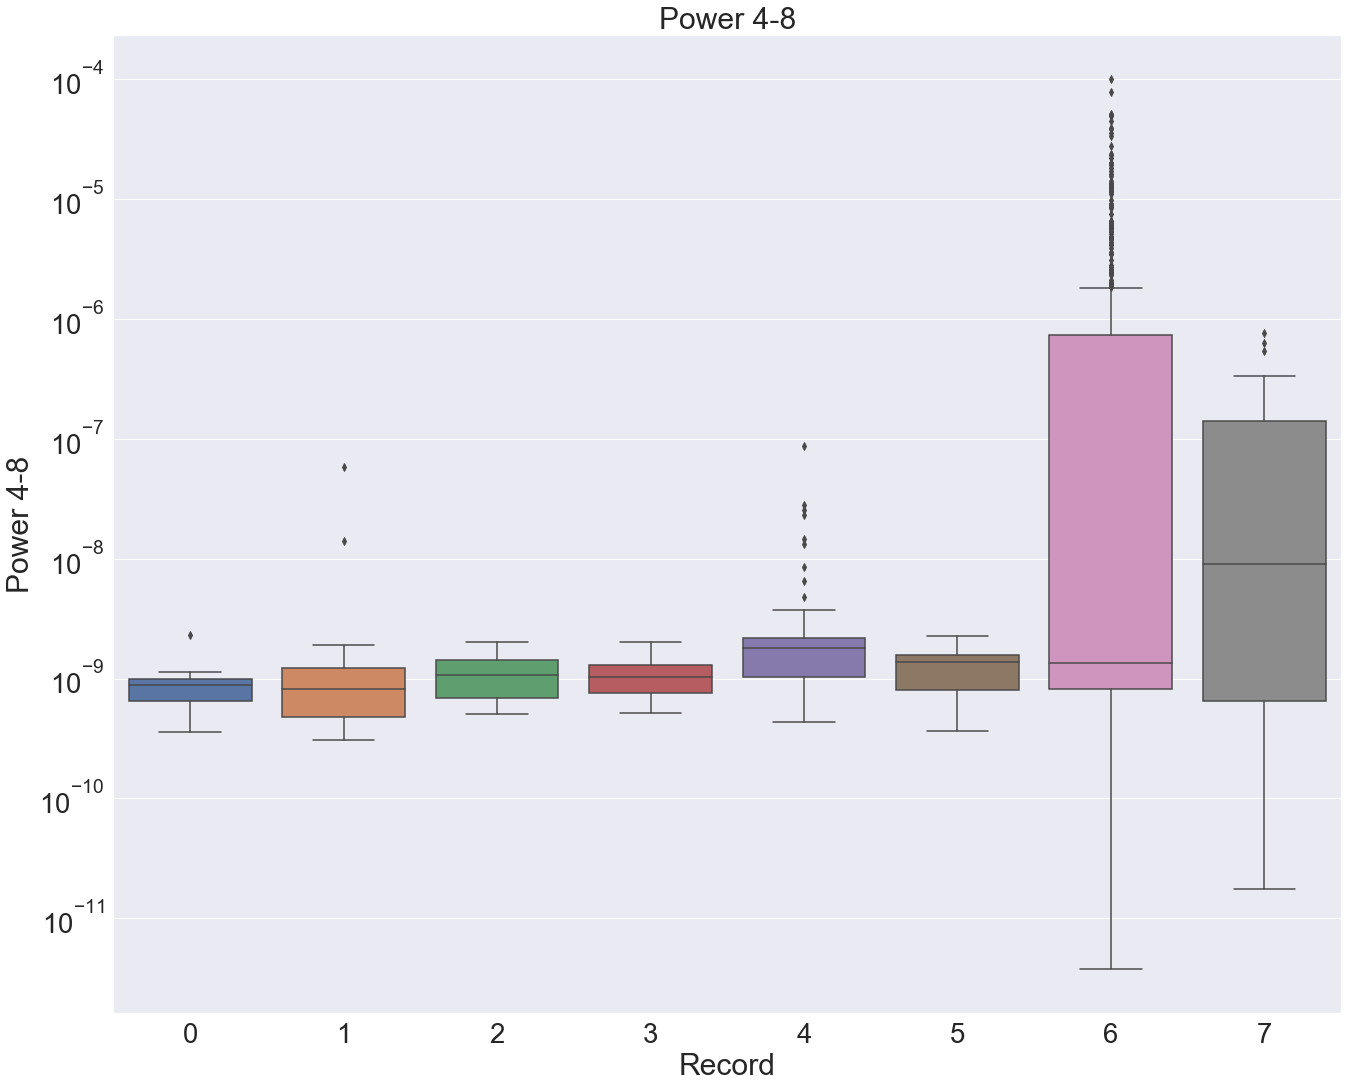

In [13]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Record", y="Power 4-8", data=new_df, ax=ax)
title("Power 4-8")
show()

/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


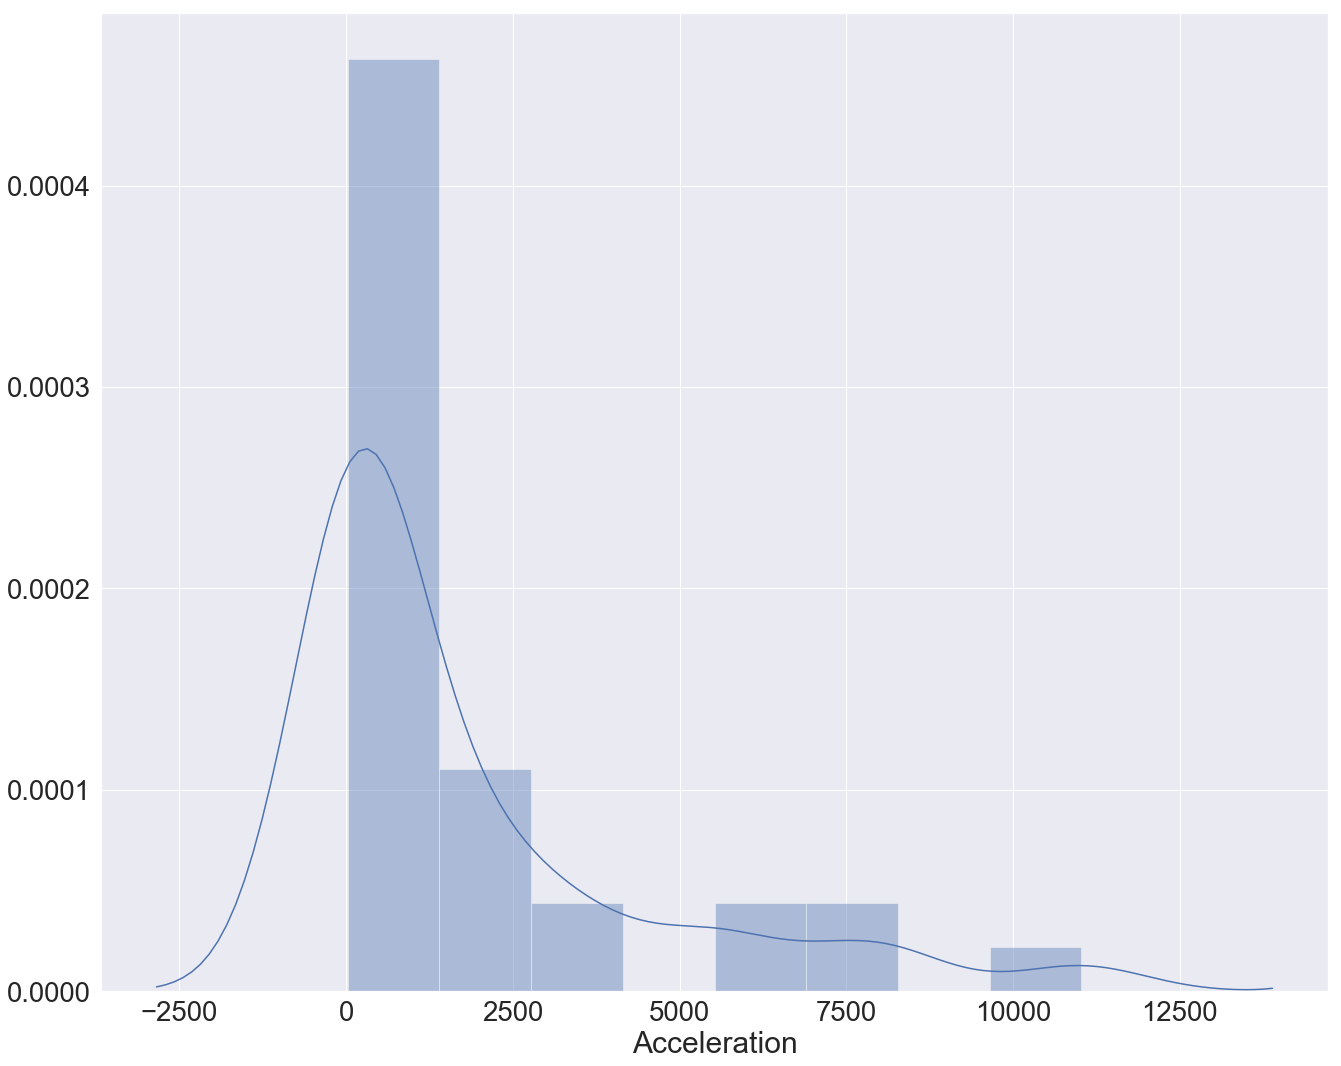

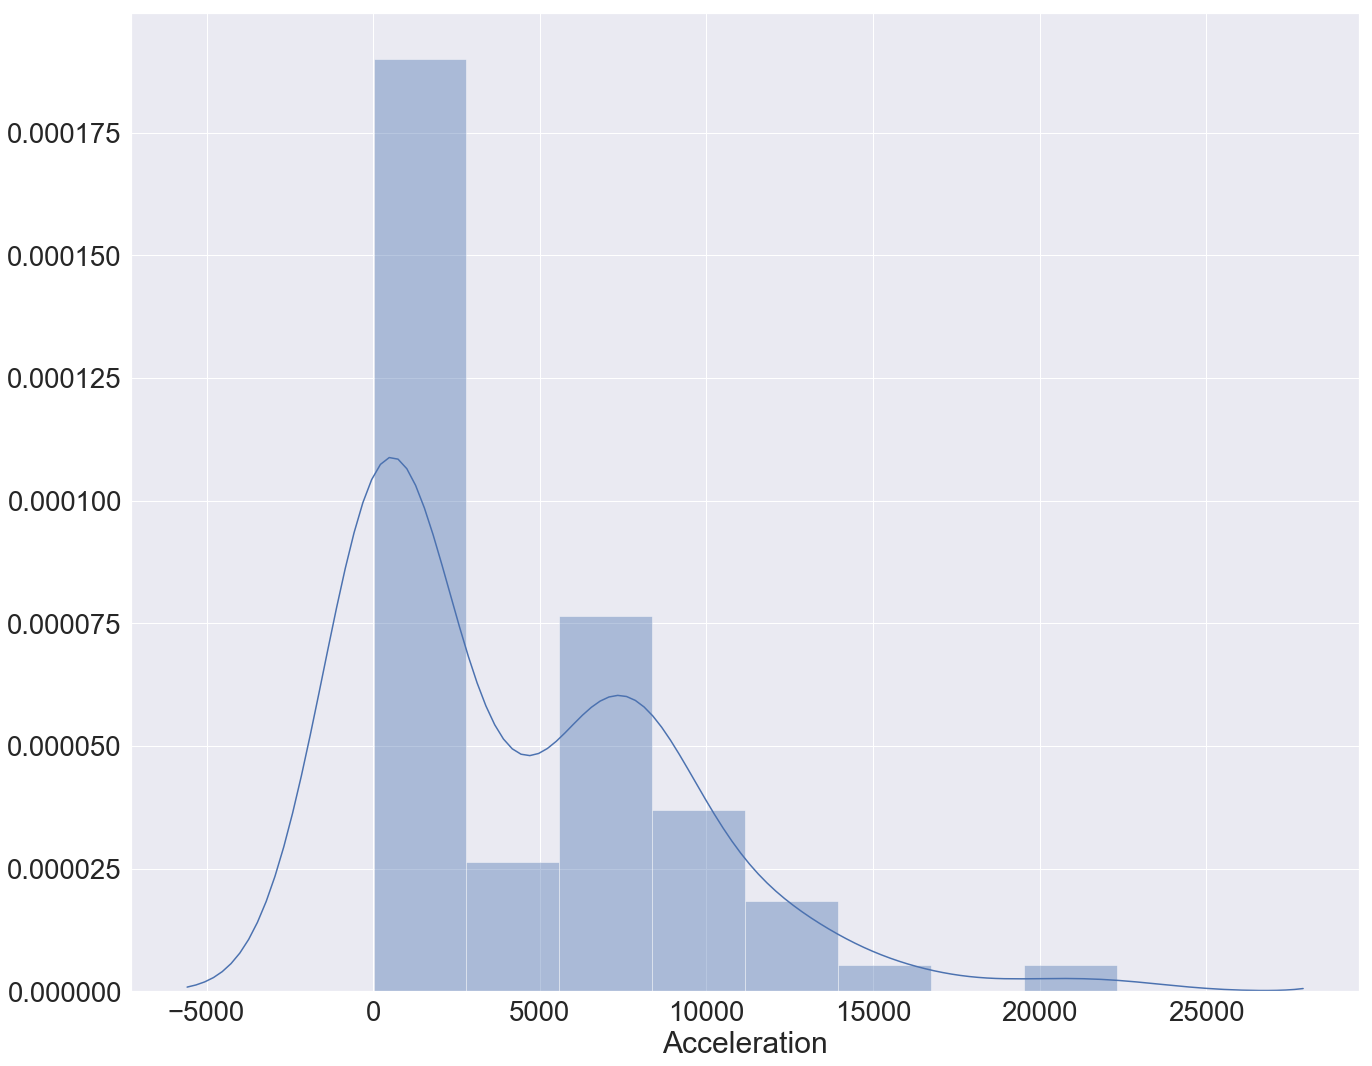

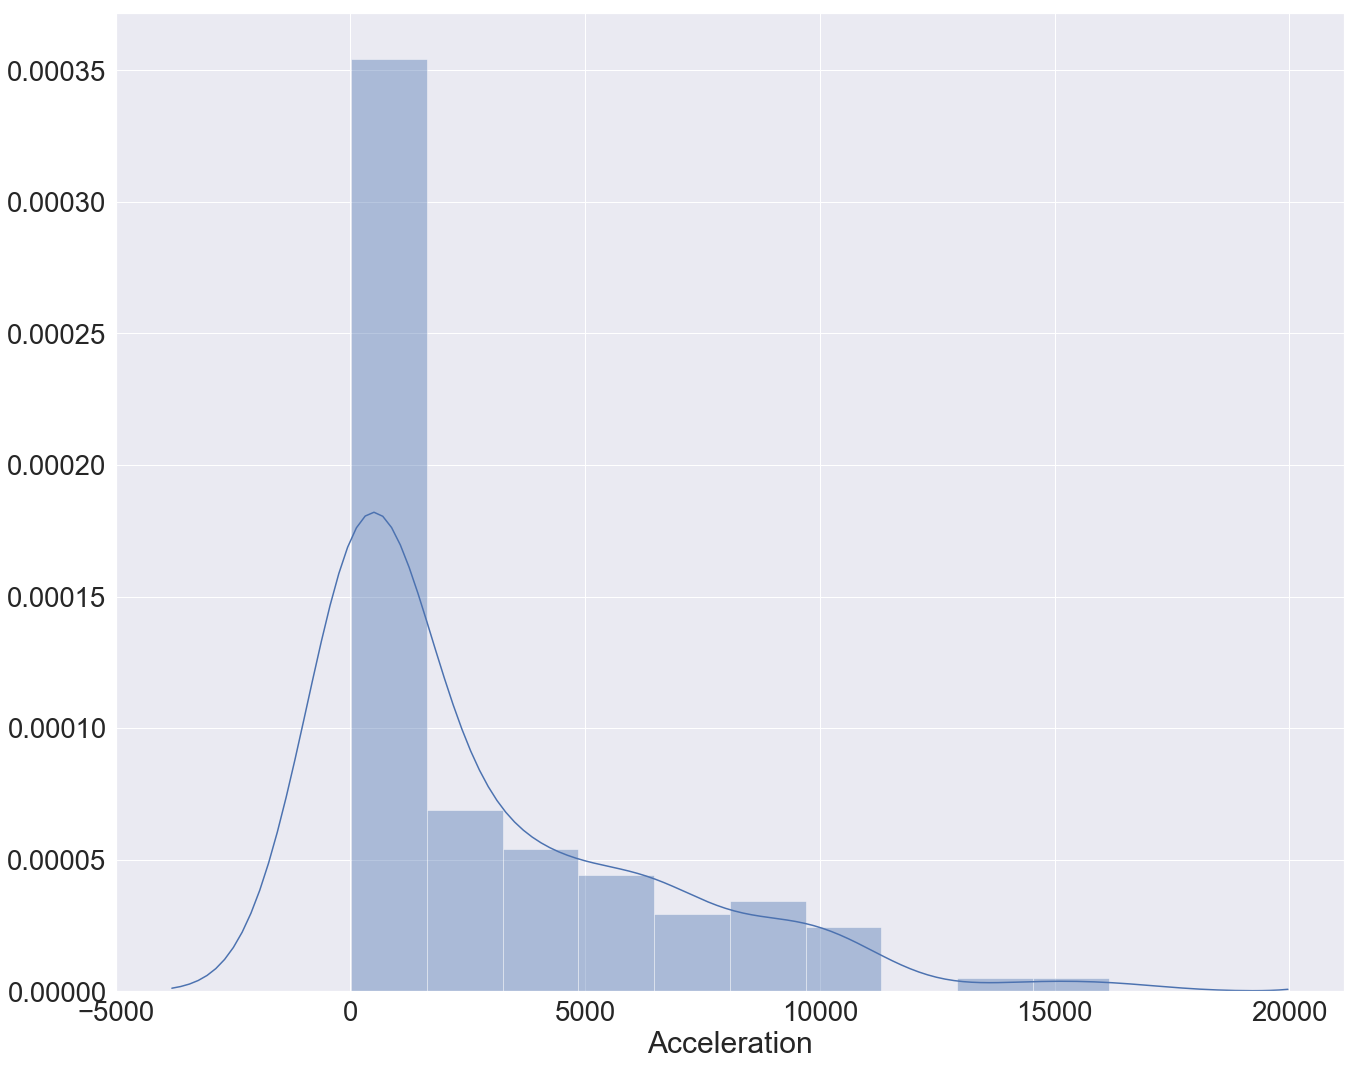

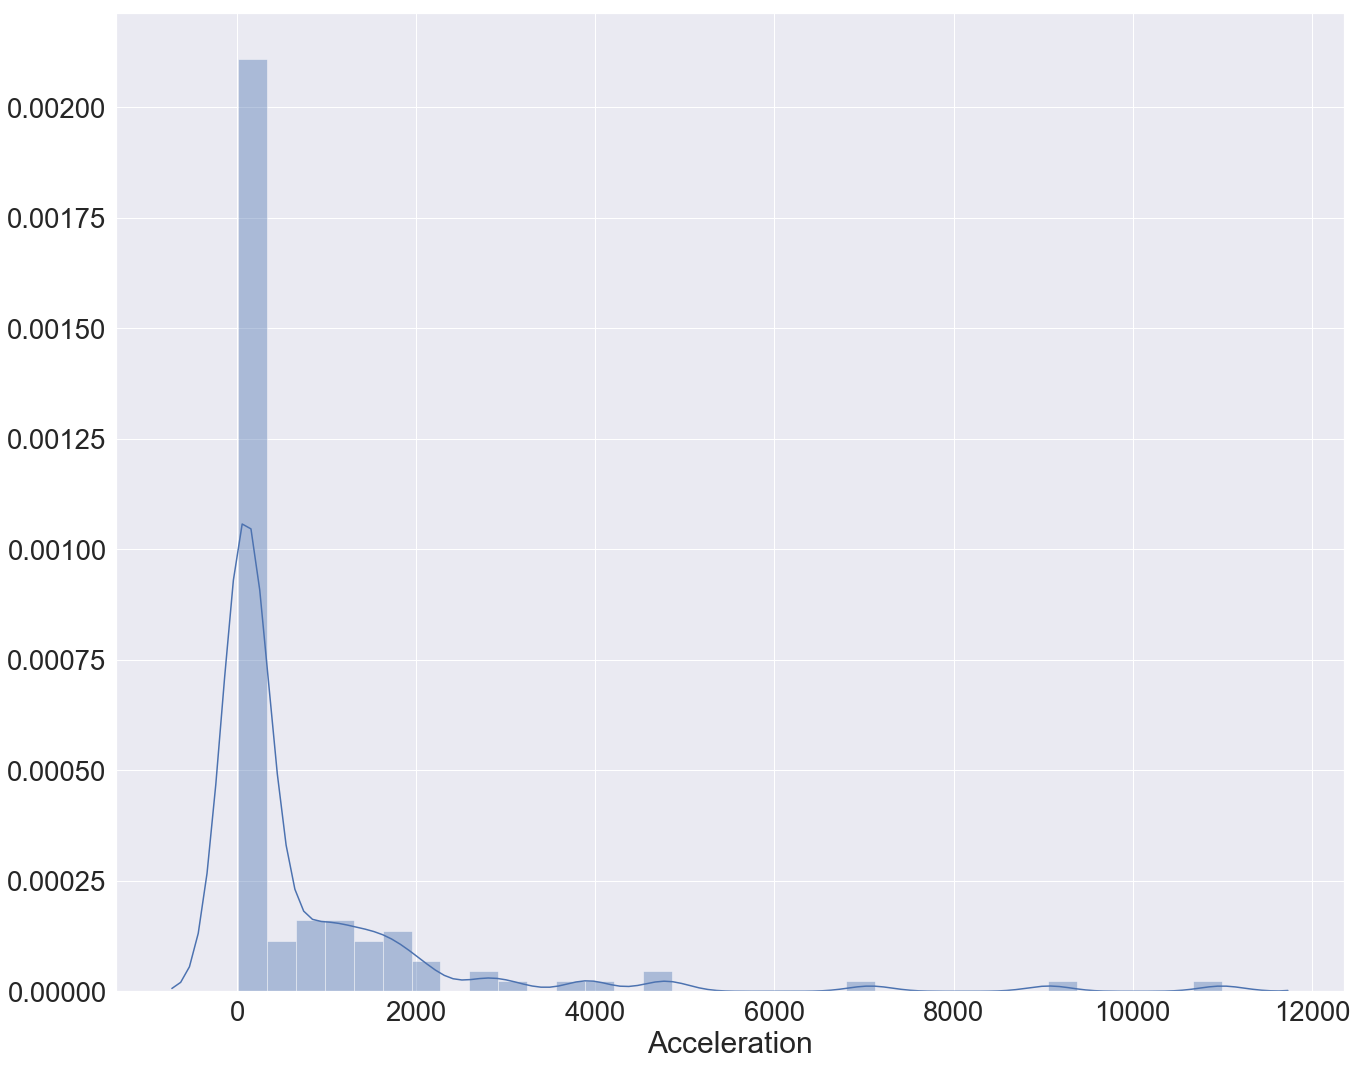

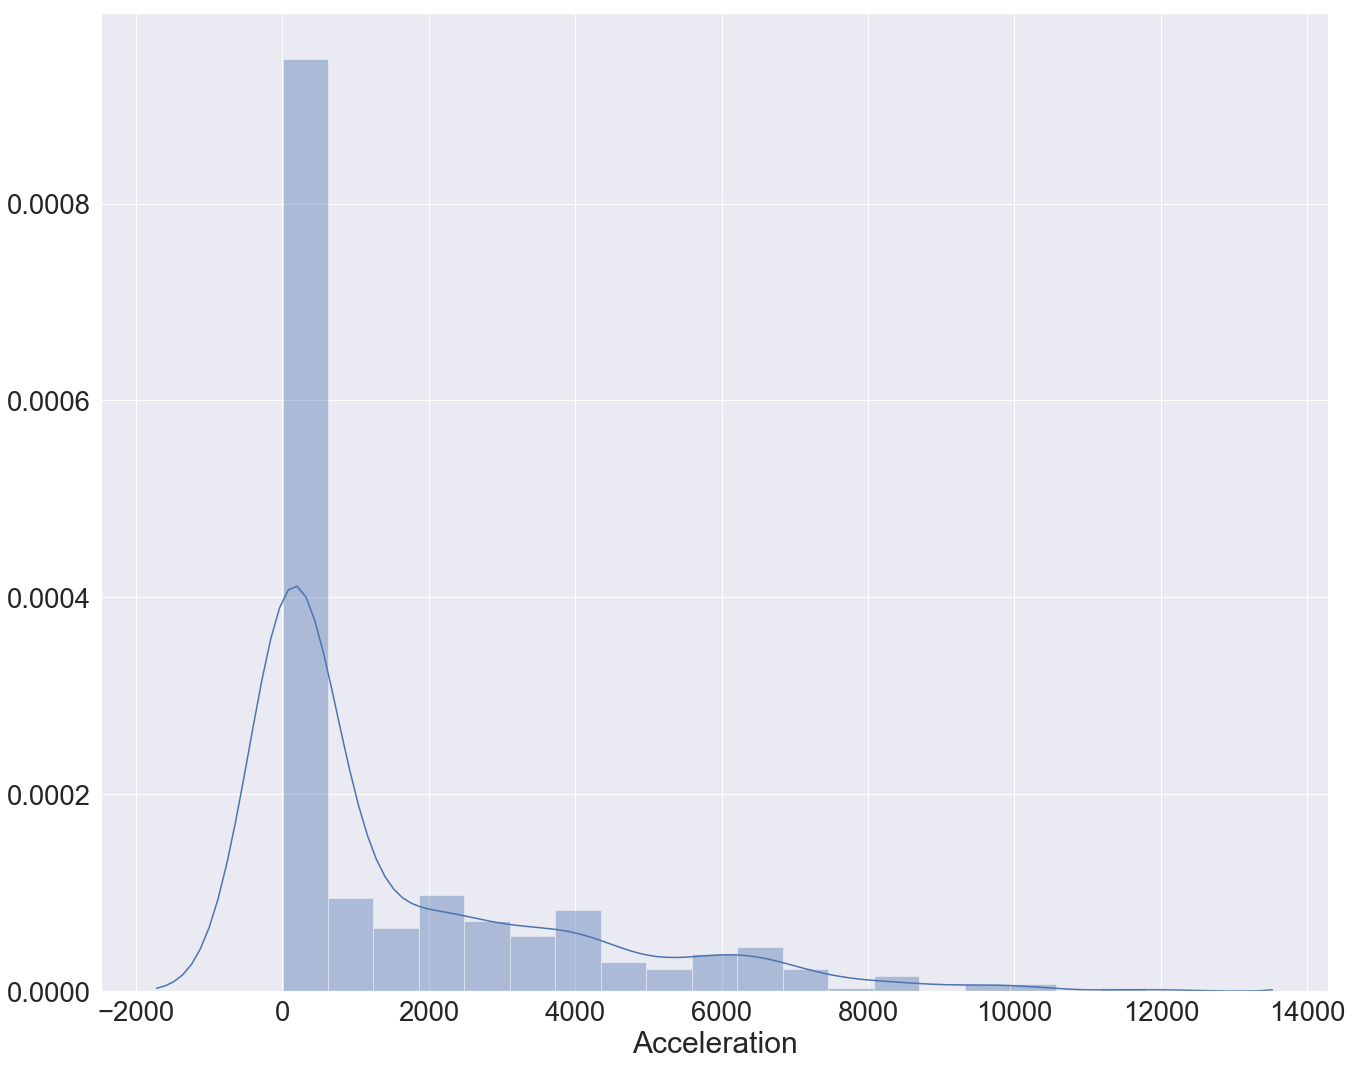

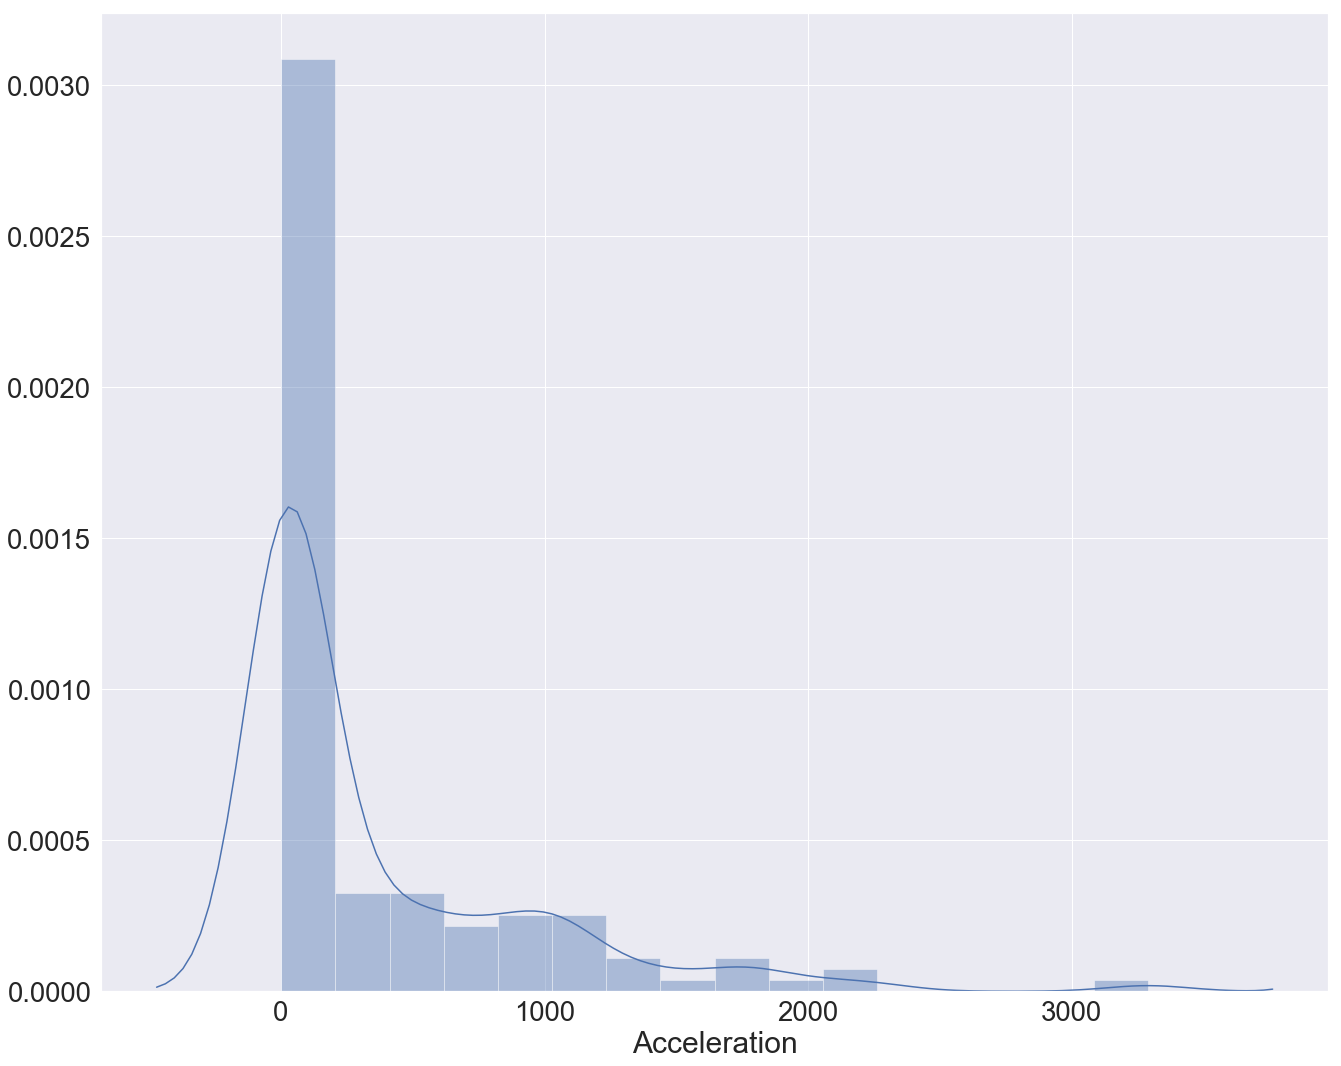

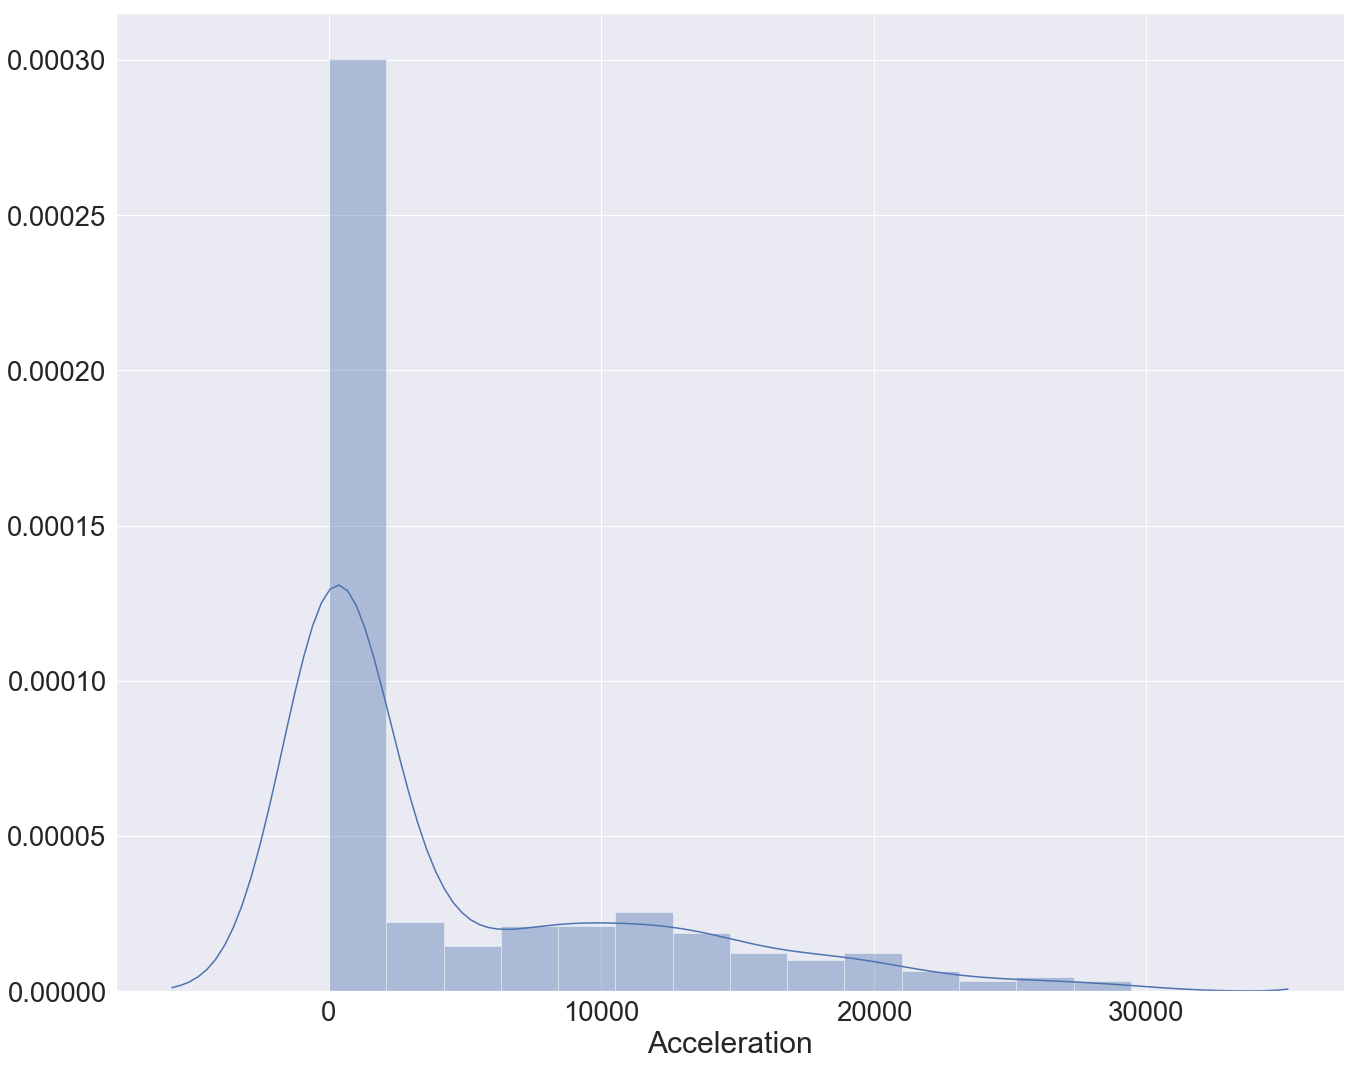

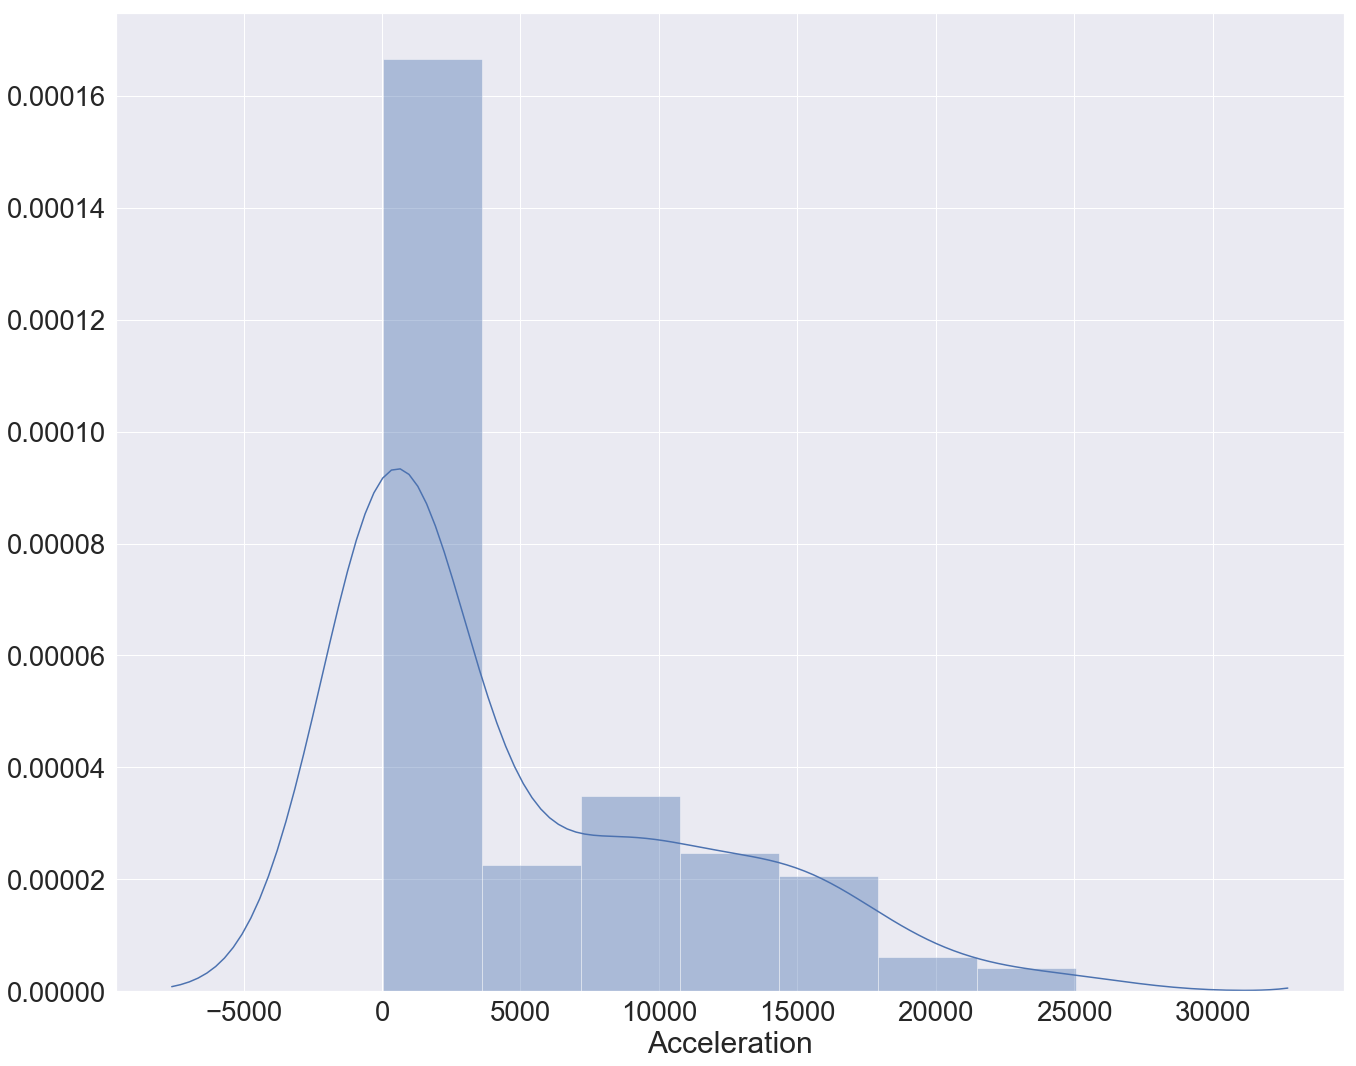

In [14]:
for i in np.arange(8):
    x = data[data["Record"]==i]["Acceleration"]
    sns.distplot(x)
    show()

In [21]:
64258249/fs/60/60

71.39805444444444